# Understanding pc_align output
David Shean  
February 2, 2024

This notebook provides a framework to ingest, analyze and visualize ASP `pc_align` output (v3.4). It is intended to help users evaluate the quality of the co-registration results.

The current test dataset is for a 2-m DEM composite and near-contemporaneous ICESat-2 altimetry pass. This should be replaced by publicly-available ArcticDEM dataset over exposed terrain and ATL06-SR points prepared on-the-fly using SlideRule Earth.

## To do:
* Sample sizes - ASP only computes 10^5 errors by default
* Add basemaps to plots
* Load the original datasets
* More careful sampling strategy - 80/20 split for cal/val

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import glob

In [2]:
topdir='/Users/dshean/scr/utqiagvik/bpurinton_stack_20231209/'

In [3]:
%cd $topdir

/Users/dshean/scr/utqiagvik/bpurinton_stack_20231209


In [4]:
#Reference should always be DEM/PC with highest density or finest GSD
ref_fn='utqiagvik_3m_stack_align_med_masked.tif'
#pt_fn='utqiagvik_ATL06-SR_test.csv'
#prefix='pc_align_test/pc_align_test'
#Source DEM/PC should be more sparse
src_fn='utqiagvik_ATL06-SR_test_20220409-20220423.csv'
prefix="pc_align_test/pc_align_test_20220409-20220423"

In [5]:
#These should be defined more carefully, need improved ASP PROJ support

#SlideRule default
#ITRF2014 geographic coordinates, ellipsoid eight
in_crs='EPSG:7912'

#Should use WKT2 to define UTM coordinates system with proper ITRF/WGS84 realization
#https://github.com/ICESAT-2HackWeek/3D_CRS_Transformation_Resources/blob/main/examples/UTM_4N_ITRF2014_3D.wkt 
#out_crs='EPSG:3413'
out_crs='EPSG:32604+EPSG:4979'

In [6]:
!pc_align --csv-format '3:lon 4:lat 5:height_above_datum' --max-displacement 10 --compute-translation-only \
--save-inv-transformed-reference-points --output-prefix {prefix} {ref_fn} {src_fn}

	--> Setting number of processing threads to: 4
Writing log info to: pc_align_test/pc_align_test_20220409-20220423-log-pc_align-02-02-1738-2516.txt
Detected datum from utqiagvik_3m_stack_align_med_masked.tif:
Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Will use datum (for CSV files): Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Computing the bounding boxes of the reference and source points using 9000000 sample points.
Computation of bounding boxes took 6.59856 [s]
Reference points box: (Origin: (-156.89, 71.2629) width: 0.544384 height: 0.137582)
Source points box:    (Origin: (-157.132, 71.1397) width: 0.622928 height: 0.374719)
Intersection reference box:  (Origin: (-156.89, 71.2629) width: 0.38127 height: 0.137582)
Intersection source    box: 

## Review output files

In [7]:
%ls $prefix*

pc_align_test/pc_align_test_20220409-20220423-beg_errors.csv
pc_align_test/pc_align_test_20220409-20220423-end_errors.csv
pc_align_test/pc_align_test_20220409-20220423-inverse-transform.txt
pc_align_test/pc_align_test_20220409-20220423-iterationInfo.csv
pc_align_test/pc_align_test_20220409-20220423-log-pc_align-01-30-2116-75784.txt
pc_align_test/pc_align_test_20220409-20220423-log-pc_align-02-02-1738-2516.txt
pc_align_test/pc_align_test_20220409-20220423-trans_reference.tif
pc_align_test/pc_align_test_20220409-20220423-transform.txt


In [8]:
initial_error_fn = glob.glob(prefix+'-beg_errors.csv')[0]
final_error_fn = glob.glob(prefix+'-end_errors.csv')[0]

In [9]:
def pc_align_errors_gdf(fn, crs='EPSG:4326'):
    df = pd.read_csv(fn, skiprows=3, names=['lon','lat','height_above_datum','error (meters)'])
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat'], df['height_above_datum']), crs=crs)
    return gdf

In [10]:
initial_error_gdf = pc_align_errors_gdf(initial_error_fn).to_crs(out_crs)
final_error_gdf = pc_align_errors_gdf(final_error_fn).to_crs(out_crs)

In [11]:
initial_error_gdf.shape

(3891, 5)

In [12]:
initial_error_gdf.head()

,lon,lat,height_above_datum,error (meters),geometry
0,-156.556604,71.398803,-1.585279,0.835302,POINT Z (586967.778 7923633.955 -1.585)
1,-156.556641,71.398714,-1.586837,0.261866,POINT Z (586966.852 7923624.001 -1.587)
2,-156.556679,71.398625,-1.606865,0.341889,POINT Z (586965.925 7923614.033 -1.607)
3,-156.556716,71.398536,-1.595318,0.523250,POINT Z (586965.002 7923604.079 -1.595)
4,-156.556753,71.398447,-1.587478,0.557934,POINT Z (586964.079 7923594.111 -1.587)


In [13]:
final_error_gdf.head()

,lon,lat,height_above_datum,error (meters),geometry
0,-156.556621,71.398794,-2.310680,0.524247,POINT Z (586967.212 7923632.988 -2.311)
1,-156.556658,71.398706,-2.312236,0.462681,POINT Z (586966.285 7923623.033 -2.312)
2,-156.556696,71.398617,-2.332262,0.345026,POINT Z (586965.358 7923613.066 -2.332)
3,-156.556733,71.398528,-2.320713,0.188444,POINT Z (586964.435 7923603.111 -2.321)
4,-156.556770,71.398439,-2.312871,0.166316,POINT Z (586963.513 7923593.143 -2.313)


## Prepare Combined GeoDataFrame

In [14]:
error_diff_gdf = initial_error_gdf.copy()

In [15]:
error_diff_gdf.rename(columns={'error (meters)':'error_initial'}, inplace=True)
error_diff_gdf['error_final'] = final_error_gdf['error (meters)']

In [16]:
#Compute error difference (assuming point order in csv is identical)
error_diff_gdf['error_diff'] = error_diff_gdf['error_final'] - error_diff_gdf['error_initial']

In [17]:
#Compute translation components in out_crs
error_diff_gdf['dx'] = final_error_gdf.geometry.x - initial_error_gdf.geometry.x 
error_diff_gdf['dy'] = final_error_gdf.geometry.y - initial_error_gdf.geometry.y
error_diff_gdf['dz'] = final_error_gdf.geometry.z - initial_error_gdf.geometry.z
error_diff_gdf['dist'] = initial_error_gdf.distance(final_error_gdf, align=True)

In [18]:
error_diff_gdf.loc[:, ['dx', 'dy', 'dz', 'dist']].describe()

,dx,dy,dz,dist
count,3891.000000,3891.000000,3891.000000,3891.000000
mean,-0.567038,-0.968576,-0.723781,1.122351
std,0.000308,0.000450,0.000737,0.000471
min,-0.567534,-0.969323,-0.725400,1.121315
25%,-0.567422,-0.968962,-0.724363,1.121980
50%,-0.567051,-0.968591,-0.723720,1.122389
75%,-0.566735,-0.968250,-0.723193,1.122728
max,-0.566614,-0.967624,-0.722390,1.123236


In [23]:
error_diff_gdf.head()

,lon,lat,height_above_datum,error_initial,geometry,error_final,error_diff,dx,dy,dz,dist
0,-156.556604,71.398803,-1.585279,0.835302,POINT Z (586967.778 7923633.955 -1.585),0.524247,-0.311056,-0.566614,-0.967624,-0.725400,1.121315
1,-156.556641,71.398714,-1.586837,0.261866,POINT Z (586966.852 7923624.001 -1.587),0.462681,0.200814,-0.566614,-0.967625,-0.725399,1.121316
2,-156.556679,71.398625,-1.606865,0.341889,POINT Z (586965.925 7923614.033 -1.607),0.345026,0.003137,-0.566614,-0.967626,-0.725397,1.121317
3,-156.556716,71.398536,-1.595318,0.523250,POINT Z (586965.002 7923604.079 -1.595),0.188444,-0.334806,-0.566615,-0.967627,-0.725395,1.121318
4,-156.556753,71.398447,-1.587478,0.557934,POINT Z (586964.079 7923594.111 -1.587),0.166316,-0.391618,-0.566615,-0.967628,-0.725394,1.121319


## Visualize key metrics

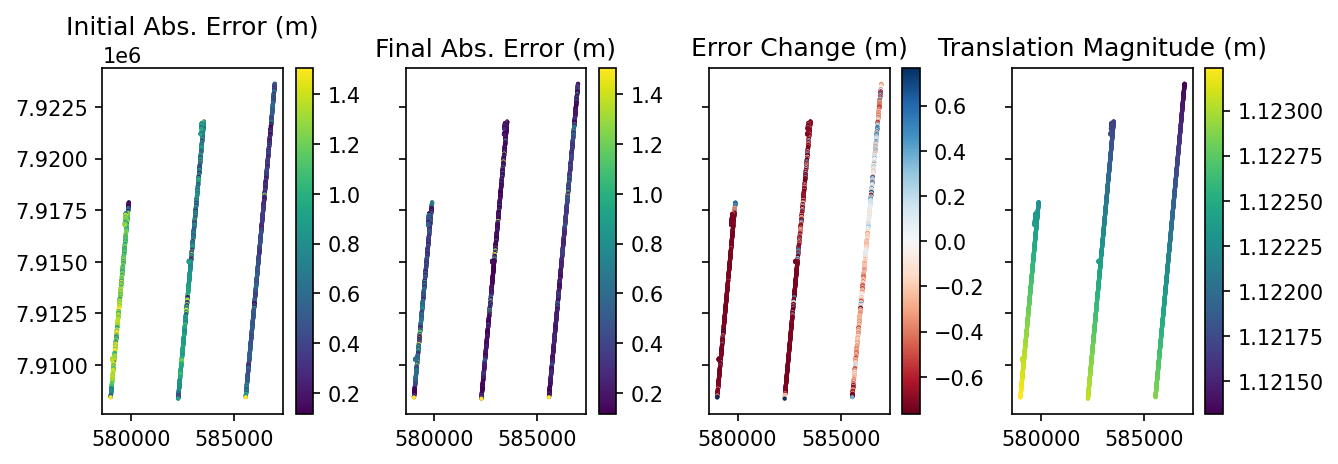

In [24]:
f, axa = plt.subplots(1,4, sharex=True, sharey=True, figsize=(10,3), dpi=150)
plot_kwargs={'legend':True, 's':1}
clim = initial_error_gdf['error (meters)'].quantile((0.02, 0.98)).values
axa[0].set_title('Initial Abs. Error (m)')
initial_error_gdf.plot(ax=axa[0], column='error (meters)', vmin=clim[0], vmax=clim[1], **plot_kwargs)
axa[1].set_title('Final Abs. Error (m)')
final_error_gdf.plot(ax=axa[1], column='error (meters)', vmin=clim[0], vmax=clim[1], **plot_kwargs)
absmax_clim = error_diff_gdf['error_diff'].quantile((0.02, 0.98)).abs().max()
axa[2].set_title('Error Change (m)')
error_diff_gdf.plot(ax=axa[2], column='error_diff', vmin=-absmax_clim, vmax=absmax_clim, cmap='RdBu', **plot_kwargs)
axa[3].set_title('Translation Magnitude (m)')
error_diff_gdf.plot(ax=axa[3], column='dist', **plot_kwargs);
#plt.tight_layout()

In [25]:
error_diff_gdf[['error_initial', 'error_final']].quantile((0.98)).max()

1.5050755717574305

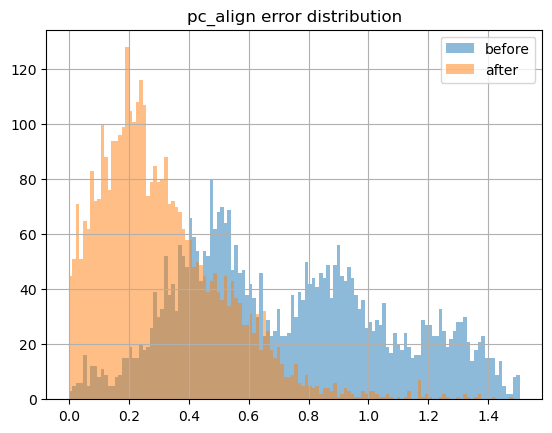

In [26]:
f, ax = plt.subplots()
xmax = error_diff_gdf[['error_initial', 'error_final']].quantile((0.98)).max()
plot_kwargs = {'bins':128, 'alpha':0.5, 'range':(0, xmax)}
error_diff_gdf.hist(ax=ax, column='error_initial', label='before', **plot_kwargs)
error_diff_gdf.hist(ax=ax, column='error_final', label='after', **plot_kwargs)
ax.legend()
ax.set_title('pc_align error distribution');